     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 6.7 MB/s eta 0:00:00


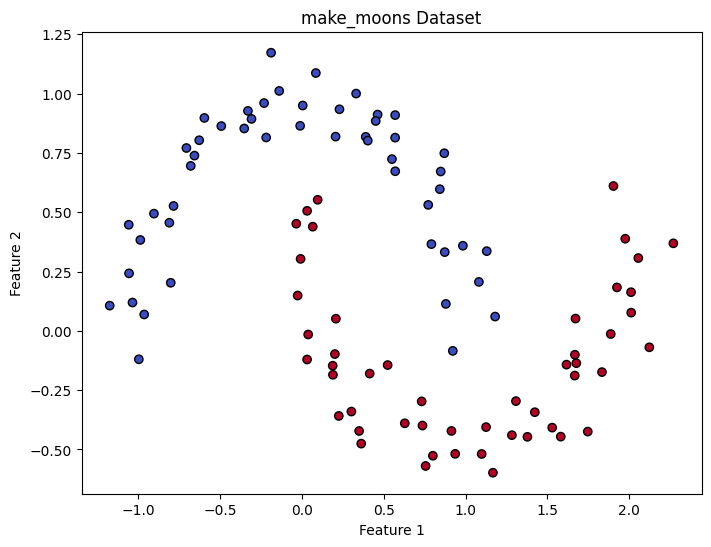

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Classification accuracy: 1.00


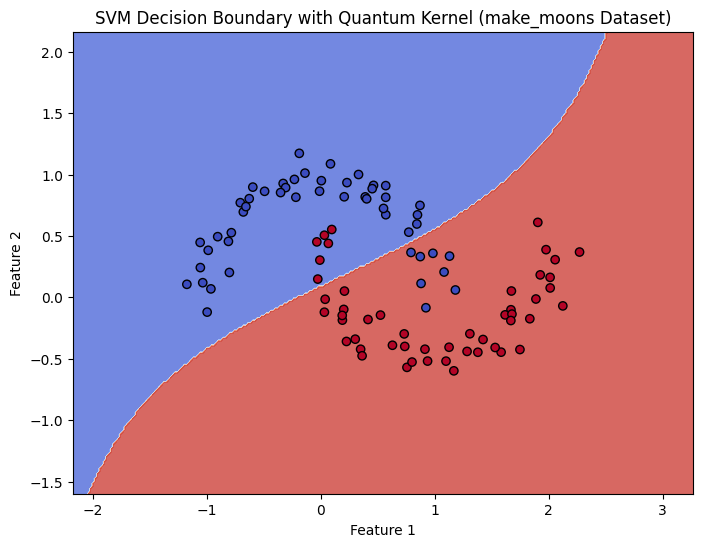

In [ ]:
# Step 1: Install the required packages
!pip install pennylane pennylane-lightning numpy scikit-learn scipy joblib matplotlib

# Step 2: Import necessary libraries
import time
import pennylane as qml
from pennylane import numpy as np
from sklearn.datasets import make_moons
from scipy.optimize import minimize
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from joblib import Parallel, delayed
import matplotlib.pyplot as plt

# Load the make_moons dataset
X, y = make_moons(n_samples=100, noise=0.1, random_state=42)

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='coolwarm', edgecolors='k')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('make_moons Dataset')
plt.show()

# Define the number of qubits
n_qubits = X.shape[1]
dev = qml.device('default.qubit', wires=n_qubits)

# Define the quantum feature map
def quantum_feature_map(x, params):
    for i in range(n_qubits):
        qml.RY(x[i % len(x)], wires=i)
    for i in range(n_qubits):
        qml.RZ(params[i], wires=i)
    qml.broadcast(qml.CNOT, wires=range(n_qubits), pattern="ring")

# Define the variational quantum circuit
@qml.qnode(dev)
def variational_circuit(x, params):
    quantum_feature_map(x, params)
    return qml.state()

# Initialize random parameters
np.random.seed(42)
params = np.random.uniform(0, np.pi, n_qubits)

def compute_qek_matrix(X, params):
    n_samples = len(X)
    qek_matrix = np.zeros((n_samples, n_samples))

    def compute_element(i, j):
        state_i = variational_circuit(X[i], params)
        state_j = variational_circuit(X[j], params)
        return np.abs(np.dot(np.conj(state_i), state_j))**2

    results = Parallel(n_jobs=-1)(delayed(compute_element)(i, j) for i in range(n_samples) for j in range(n_samples))
    qek_matrix = np.array(results).reshape(n_samples, n_samples)

    return qek_matrix

qek_matrix = compute_qek_matrix(X, params)

# Define the kernel-target alignment objective
def kernel_target_alignment(params, X, y):
    qek_matrix = compute_qek_matrix(X, params)
    y_matrix = np.outer(y, y)
    alignment = np.sum(qek_matrix * y_matrix)
    return -alignment  # Negate for minimization

# Optimize the parameters
result = minimize(kernel_target_alignment, params, args=(X, y), method='COBYLA')
optimized_params = result.x

# Compute the optimized QEK matrix
optimized_qek_matrix = compute_qek_matrix(X, optimized_params)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Extract the corresponding training and testing indices for the QEK matrices
train_indices = np.array([np.where((X == train_instance).all(axis=1))[0][0] for train_instance in X_train])
test_indices = np.array([np.where((X == test_instance).all(axis=1))[0][0] for test_instance in X_test])

# Ensure the correct dimensions for the training and testing matrices
K_train = optimized_qek_matrix[np.ix_(train_indices, train_indices)]
K_test = optimized_qek_matrix[np.ix_(test_indices, train_indices)]

# Train the SVM classifier
svm = SVC(kernel='precomputed')
svm.fit(K_train, y_train)

# Evaluate the classifier
accuracy = svm.score(K_test, y_test)
print(f'Classification accuracy: {accuracy:.2f}')

# Plot the SVM decision boundary
h = .02  # step size in the mesh
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Create a function to predict with the quantum kernel
def predict_with_quantum_kernel(X_train, X_new, optimized_qek_matrix):
    n_train = len(X_train)
    n_new = len(X_new)
    K_new = np.zeros((n_new, n_train))

    for i in range(n_new):
        for j in range(n_train):
            state_i = variational_circuit(X_new[i], optimized_params)
            state_j = variational_circuit(X_train[j], optimized_params)
            K_new[i, j] = np.abs(np.dot(np.conj(state_i), state_j))**2

    return K_new

# Predict the entire meshgrid
Z = predict_with_quantum_kernel(X_train, np.c_[xx.ravel(), yy.ravel()], optimized_qek_matrix)
Z = svm.predict(Z)
Z = Z.reshape(xx.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.8, cmap='coolwarm')
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', cmap='coolwarm')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('SVM Decision Boundary with Quantum Kernel (make_moons Dataset)')
plt.show()
